In [1]:
import pandas as pd
import numpy as np
import numpy as np
import re
import seaborn as sns
from scipy import stats
import math
import operator
import plotly
import plotly.plotly as py
import plotly.tools as tls
import plotly.graph_objs as go
from plotly.graph_objs import *
from plotly.offline import init_notebook_mode, iplot, plot
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10, 10
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import feather

#### Comenzaremos con los siguientes pasos:
    * Cargar el dataset "limpio"
    * Eliminar columnas que no vamos a utilizar
    * Eliminar registros nulos en cero y valores "raros" que encontremos

In [2]:
### Cargar dataset "limpio"
df = feather.read_dataframe("Data/principal.feather")
df.sample(1)

,property_type,lat-lon,lat,lon,price,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,ambientes,provincia,partido,localidad,condicion,price_aprox_usd_levels,geonames_id
22338,2,"-37.9949915,-57.56460300000001",-37.994991,-57.564603,NaN,NaN,320.0,NaN,NaN,NaN,6.0,3.0,50.0,NaN,NaN,NaN,3430863.0


#### Eliminamos columnas que no vamos a utilizar

In [3]:
to_drop = [
            'price_usd_per_m2', 
            'price_per_m2', 
            'price',
            'provincia',
            'localidad',
            'condicion',
            'geonames_id', 
            'lat-lon',
            'lat','lon',
            'price_aprox_usd_levels',
]

df.drop(columns=to_drop, inplace=True) #aplicar drop
print("Cantidad de registros:",len(df))
df.sample(1)

Cantidad de registros: 121220


,property_type,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,ambientes,partido
9301,2,190000.0,240.0,240.0,NaN,4.0


#### Eliminamos nulos de las columnas principales

In [4]:
columnas_principales = ['price_aprox_usd','surface_total_in_m2', 'ambientes','surface_covered_in_m2','partido']
df = df.dropna(axis =0 , how = 'any', subset = columnas_principales)
df.shape

(70827, 6)

In [5]:
df.isnull().sum()

property_type            0
price_aprox_usd          0
surface_total_in_m2      0
surface_covered_in_m2    0
ambientes                0
partido                  0
dtype: int64

In [6]:
# quito ambientes nulos y valores muy altos
mask_ambientes = (df.ambientes > 0)&(df.ambientes < 100)
df = df[mask_ambientes]

In [7]:
df.describe()

,property_type,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,ambientes,partido
count,70780.000000,70780.000000,70780.000000,70780.000000,70780.000000,70780.000000
mean,1.244377,189291.800615,130.877304,89.826702,3.208477,106.377748
std,0.561986,141712.305267,164.309079,80.186571,1.552792,119.844074
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,1.000000,90000.000000,45.000000,40.000000,2.000000,14.000000
50%,1.000000,140000.000000,73.493411,63.000000,3.000000,50.000000
75%,2.000000,240000.000000,152.906751,119.000000,4.000000,154.000000
max,3.000000,815000.000000,1490.000000,485.000000,72.000000,538.000000


### Analisis de relacion entre variables
**Vamos a crear nuevas variables para evaluar la matriz de correlacion y seleccionar las que den mejor valor contr price_aprox_usd**

In [8]:
# vamos probando  el efecto entre varias combinaciones
df['surface_by_amb'] = df.surface_total_in_m2/df.ambientes
df['surface_by_add'] = df.surface_total_in_m2+df.surface_covered_in_m2
df['surface_covered_prop'] = df.surface_covered_in_m2/df.surface_total_in_m2
df['surface_total_prop_cov'] = df.surface_total_in_m2/df.surface_covered_in_m2
df['surface_cov_complete'] = df.surface_covered_in_m2.fillna(df.surface_total_in_m2)
df['new_rel1'] = (df.surface_total_in_m2+df.surface_covered_in_m2)+df.ambientes
df['new_rel2'] = df.surface_cov_complete+df.surface_total_prop_cov
df['new_rel3'] = (df.surface_cov_complete+df.surface_total_prop_cov)/df.ambientes
df['new_rel4'] = (df.surface_cov_complete/df.ambientes)
df['new_rel5'] = (df.surface_cov_complete+df.surface_total_prop_cov/df.ambientes)
df['new_rel6'] = ((df.surface_cov_complete/df.ambientes)+df.surface_total_prop_cov)
df.sample(1)

,property_type,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,ambientes,partido,surface_by_amb,surface_by_add,surface_covered_prop,surface_total_prop_cov,surface_cov_complete,new_rel1,new_rel2,new_rel3,new_rel4,new_rel5,new_rel6
98052,2,25237.09,55.0,55.0,2.0,234.0,27.5,110.0,1.0,1.0,55.0,112.0,56.0,28.0,27.5,55.5,28.5


#### Matriz de correlacion

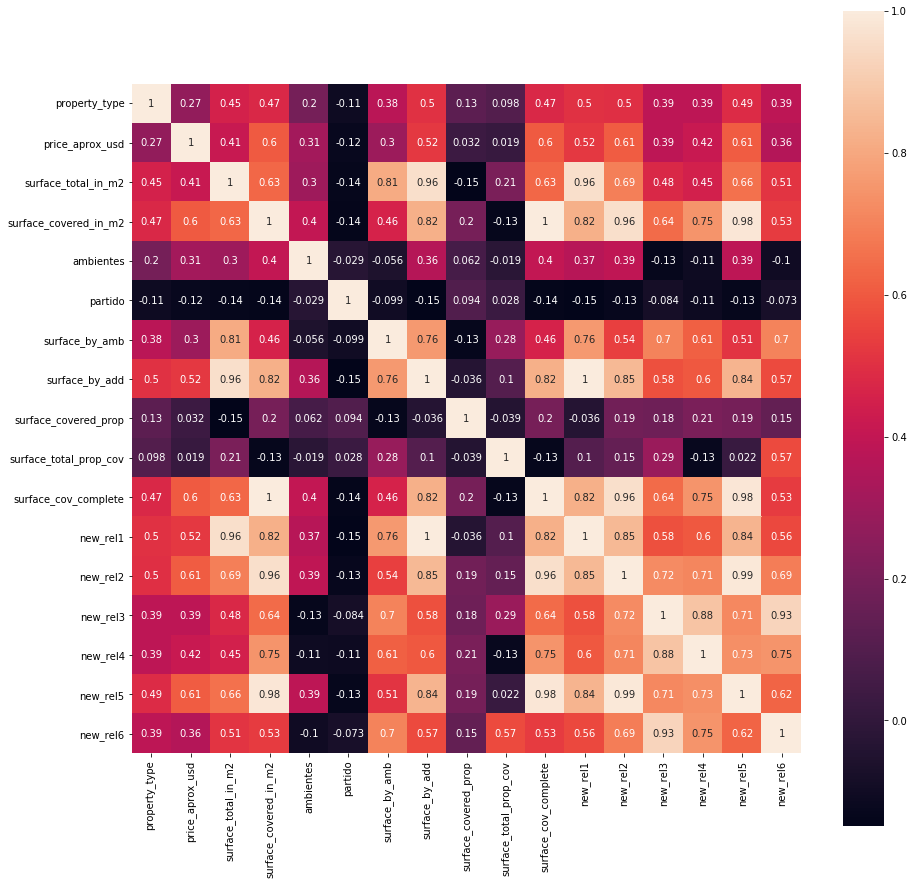

In [9]:
fig, ax = plt.subplots(figsize=(15,15))       
sns.heatmap(df.corr() , square=True, annot=True, ax=ax);

##### En la matriz observamos que los valores con mayor valor para precio son:
    * new_rel2.61
    * new_rel5 =.61
    * surface_cov_in_m2 = .60
##### Vamos a entrenar un modelo utilizando new_rel2 y new_rel5

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning:

invalid value encountered in reduce

/opt/conda/lib/python3.6/site-packages/numpy/linalg/linalg.py:1876: RuntimeWarning:

invalid value encountered in greater



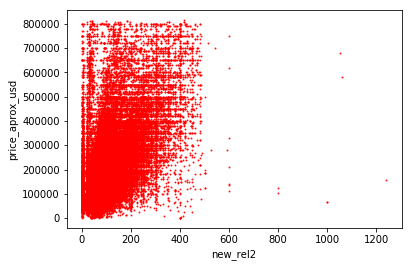

In [10]:
#reviso relación entre new_rel2 y price_aprox_usd
sns.regplot(df.new_rel2,df.price_aprox_usd, order=1, ci=None, scatter_kws={'color':'r', 's':1})
# ಠ ʖ̯ ͡ಠ

#### Creamos y almacenamos dataset de train y test
Analizamos valores en new_rel2 y new_rel5

In [11]:
df.describe()

,property_type,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,ambientes,partido,surface_by_amb,surface_by_add,surface_covered_prop,surface_total_prop_cov,surface_cov_complete,new_rel1,new_rel2,new_rel3,new_rel4,new_rel5,new_rel6
count,70780.000000,70780.000000,70780.000000,70780.000000,70780.000000,70780.000000,70780.000000,70780.000000,7.077900e+04,7.077900e+04,70780.000000,70780.000000,7.077900e+04,7.077900e+04,70780.000000,7.077900e+04,7.077900e+04
mean,1.244377,189291.800615,130.877304,89.826702,3.208477,106.377748,42.350445,220.704007,inf,inf,89.826702,223.912484,inf,inf,29.437198,inf,inf
std,0.561986,141712.305267,164.309079,80.186571,1.552792,119.844074,57.540919,223.876511,NaN,NaN,80.186571,224.446762,NaN,NaN,28.083622,NaN,NaN
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,2.000000,1.000000e+00,1.428571e-01,0.000000,1.000000e+00,4.000000e-01
25%,1.000000,90000.000000,45.000000,40.000000,2.000000,14.000000,17.758504,87.000000,7.223250e-01,1.000000e+00,40.000000,89.000000,4.239024e+01,1.668707e+01,15.750000,4.069221e+01,1.817647e+01
50%,1.000000,140000.000000,73.493411,63.000000,3.000000,50.000000,26.666667,139.497218,8.730159e-01,1.145455e+00,63.000000,142.000000,6.600000e+01,2.352931e+01,22.500000,6.433333e+01,2.487778e+01
75%,2.000000,240000.000000,152.906751,119.000000,4.000000,154.000000,45.000000,276.320965,1.000000e+00,1.384418e+00,119.000000,281.000000,1.211667e+02,3.600000e+01,34.750000,1.200292e+02,3.801292e+01
max,3.000000,815000.000000,1490.000000,485.000000,72.000000,538.000000,1354.000000,1916.000000,inf,inf,485.000000,1921.000000,inf,inf,480.000000,inf,inf


In [12]:
# Por alguna razon existen valores infinitos: Los eliminamos
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["new_rel2","new_rel5"], how="all")
print("Cantidad de registros:",len(df))
df.describe()

Cantidad de registros: 70772


,property_type,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,ambientes,partido,surface_by_amb,surface_by_add,surface_covered_prop,surface_total_prop_cov,surface_cov_complete,new_rel1,new_rel2,new_rel3,new_rel4,new_rel5,new_rel6
count,70772.000000,70772.000000,70772.000000,70772.000000,70772.000000,70772.000000,70772.000000,70772.000000,70666.000000,70772.000000,70772.000000,70772.000000,70772.000000,70772.000000,70772.000000,70772.000000,70772.000000
mean,1.244405,189300.438698,130.886531,89.836856,3.208557,106.371234,42.353077,220.723388,3.356665,4.156423,89.836856,223.931945,93.993279,31.233549,29.440526,91.629879,33.596949
std,0.562012,141717.792413,164.315885,80.185416,1.552852,119.849198,57.543575,223.881603,14.577584,22.736171,80.185416,224.451841,80.384082,30.375352,28.083465,79.981617,33.846474
min,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000806,0.000000,1.000000,2.000000,1.000000,0.142857,0.090909,1.000000,0.400000
25%,1.000000,90000.000000,45.000000,40.000000,2.000000,14.000000,17.758504,87.000000,0.722325,1.000000,40.000000,89.000000,42.382616,16.687075,15.750000,40.688605,18.176471
50%,1.000000,140000.000000,73.535730,63.000000,3.000000,50.000000,26.666667,139.583058,0.872727,1.145455,63.000000,142.000000,66.000000,23.523810,22.500000,64.333333,24.877209
75%,2.000000,240000.000000,152.906751,119.000000,4.000000,154.000000,45.000000,276.482151,1.000000,1.384418,119.000000,281.000000,121.166667,36.000000,34.750000,120.008333,38.000000
max,3.000000,815000.000000,1490.000000,485.000000,72.000000,538.000000,1354.000000,1916.000000,480.000000,1240.000000,485.000000,1921.000000,1241.000000,1241.000000,480.000000,1241.000000,1241.000000


### Create train and test dataset
Creamos un dataframe de test y train: Almacenamos df_test y continuamos trabajando con df_train

In [13]:
# Create train and test dataset
msk = np.random.rand(len(df)) < 0.75
df_train = df[msk]
df_test = df[~msk]
print("Cantidad registros train: ",len(df_train))
print("Cantidad registros test: ",len(df_test))

Cantidad registros train:  53067
Cantidad registros test:  17705


In [14]:
#<<Checkpoint: TEST_TRAIN_DF>>: guardo resultados en feather (Instalacion:  conda install -c conda-forge feather-format)
feather.write_dataframe(df_train, 'Data/train.feather')
feather.write_dataframe(df_test, 'Data/test.feather')

#recargo resultados
# df_train = feather.read_dataframe('Data/train.feather')
# df_test = feather.read_dataframe('Data/test.feather')

df_train.sample(1)

,property_type,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,ambientes,partido,surface_by_amb,surface_by_add,surface_covered_prop,surface_total_prop_cov,surface_cov_complete,new_rel1,new_rel2,new_rel3,new_rel4,new_rel5,new_rel6
80882,1,100000.0,2.0,48.0,2.0,29.0,1.0,50.0,24.0,0.041667,48.0,52.0,48.041667,24.020833,24.0,48.020833,24.041667


In [15]:
#  Rompo todas las columnas que no voy a utilizar
# ◔̯◔
to_drop = [
            'new_rel1', 'new_rel3', 'new_rel4', 'new_rel6', 
            'surface_by_amb','surface_by_add',
            'surface_covered_prop','surface_total_prop_cov',
            'surface_cov_complete','ambientes',
            'surface_covered_in_m2',
            'surface_total_in_m2',
#             'property_type',
] 
df_train.drop(columns=to_drop, inplace=True) #aplicar drop
df_train.sample(1)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,property_type,price_aprox_usd,partido,new_rel2,new_rel5
55755,0,87000.0,1.0,84.146341,82.715447


In [16]:
df_train.describe()

,property_type,price_aprox_usd,partido,new_rel2,new_rel5
count,53067.000000,53067.000000,53067.000000,53067.000000,53067.000000
mean,1.246594,189997.194962,106.413609,94.364055,92.005230
std,0.562142,142213.530305,120.043731,80.612743,80.176133
min,0.000000,0.000000,0.000000,1.000000,1.000000
25%,1.000000,90000.000000,14.000000,42.781899,40.806250
50%,1.000000,141999.000000,50.000000,66.123077,64.500000
75%,2.000000,241021.625000,154.000000,121.375000,120.250000
max,3.000000,815000.000000,538.000000,1061.000000,1061.000000


In [17]:
# Elimino nulos en todas las columas
columnas_principales_train = ['price_aprox_usd','partido','new_rel2','new_rel5']
df_train = df_train.dropna(axis =0 , how = 'any', subset = columnas_principales_train)
print(df_train.shape)
# Elimino un cero de la columna price
df_train = df_train[df_train.price_aprox_usd>0]
print(df_train.shape)

(53067, 5)
(53066, 5)


#### Plot Pairwaise

In [ ]:
g = sns.pairplot(df_train)

#### Crear dummies para las siguientes categoricas:
    * partido
    * property_type

In [18]:
#### *partido
df_train = pd.concat([df_train, pd.get_dummies(data = df_train['partido'], prefix= 'dum_part')], axis = 1)
#### *property_type
df_train = pd.concat([df_train, pd.get_dummies(data = df_train['property_type'], prefix= 'dum_tprop')], axis = 1)

##### Dropeamos columnas pasadas a dummies

In [19]:
to_drop = [
            'partido', 
            'property_type',
] 
df_train.drop(columns=to_drop, inplace=True) #aplicar drop
df_train.sample(1)

,price_aprox_usd,new_rel2,new_rel5,dum_part_0.0,dum_part_1.0,dum_part_2.0,dum_part_3.0,dum_part_4.0,dum_part_5.0,dum_part_6.0,...,dum_part_528.0,dum_part_529.0,dum_part_534.0,dum_part_535.0,dum_part_536.0,dum_part_538.0,dum_tprop_0,dum_tprop_1,dum_tprop_2,dum_tprop_3
23450,119990.0,153.845297,151.711324,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Probamos score de modelos de regresion lineal combinando nuestras variables
***Pruebo score del modelo con las siguientes combinaciones:***
    * new_rel2, property_type y partido
    * new_rel5, property_type y partido
    * new_rel2, new_rel5, property_type y partido

A continuación no se muestran todos los resultados, pero al final se puede ver el score para cada test realizado:

In [20]:
#Test1: Solo new_rel2
X = df_train.drop(['price_aprox_usd','new_rel5'], axis = 1)
#Test2: Solo new_rel5
# X = df_train.drop(['price_aprox_usd','new_rel2'], axis = 1)
#Test3: new_rel2 y new_rel5
# X = df_train.drop(['price_aprox_usd'], axis = 1)
y = df_train['price_aprox_usd']

# Train y Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
X.sample(2)

,new_rel2,dum_part_0.0,dum_part_1.0,dum_part_2.0,dum_part_3.0,dum_part_4.0,dum_part_5.0,dum_part_6.0,dum_part_7.0,dum_part_8.0,...,dum_part_528.0,dum_part_529.0,dum_part_534.0,dum_part_535.0,dum_part_536.0,dum_part_538.0,dum_tprop_0,dum_tprop_1,dum_tprop_2,dum_tprop_3
91465,109.287037,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
59754,55.000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [21]:
# Regresion linear
lm = LinearRegression()

model = lm.fit(X_train, y_train)
predictions = lm.predict(X_train)
model_score = model.score(X_test, y_test)
print('Model Score:',model_score)

Model Score: -477046512959210.25


##### Resultado:
Todas las pruebas se hacen probando con **dummies** en **property_types** y **partido**
 * score con **new_rel2**: 0.5402761236330905
 * score con **new_rel5**: 0.5344155375650685
 * score con **new_rel2** y **new_rel5**: 0.5404537942097489
 
 ***Conclusión: Como el mejor score lo obtuvimos new_rel2 seguimos con esta variable (new_rel2 y new_rel5 juntas no son considerablemente mejores)***
 